In [1]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#keras tuner
# import keras_tuner
# from keras_tuner import RandomSearch
# from keras_tuner.engine.hyperparameters import HyperParameters

#transfer learning
from keras.applications.vgg16 import VGG16

#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

2024-04-10 23:16:41.112408: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 23:16:42.829855: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


we are currently using tensorflow version 2.13.0


In [2]:
train_dir = r'data/RiceLeafsDisease/train'
test_dir = r'data/RiceLeafsDisease/validation'

val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [3]:
BATCH_SIZE = 16
seeds = 41
im_shape = (250,250)

In [4]:
# Load and preprocess the training data
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1./255)

# Generator of Train
train_generator = train_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=True, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="training")
# Generator of validation
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="validation")

# Generator of dataset test
test_generator = test_generator.flow_from_directory(test_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)


Found 1680 images belonging to 6 classes.
Found 420 images belonging to 6 classes.
Found 528 images belonging to 6 classes.
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


## VGG16

In [5]:
from tensorflow.keras.applications import VGG16

In [6]:
vgg_base = VGG16(  
    include_top=False,  
    weights='imagenet',  
    input_shape=(250, 250, 3),  
)  
  
vgg_base.trainable = False  
  
set_trainable = False  
  
for layer in vgg_base.layers:  
    if layer.name == 'block5_conv1':  
        set_trainable = True  
    if set_trainable:  
        layer.trainable = True  
  
vgg_model = Sequential()  
  
vgg_model.add(vgg_base)  
   
vgg_model.add(Flatten())  
 
vgg_model.add(Dense(200, activation='relu'))  
 
vgg_model.add(Dense(6, activation='softmax'))  
  
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


2024-04-10 23:17:02.568179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 23:17:02.695566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 23:17:02.696109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

58889256/58889256 [==============================] - 6s 0us/step


In [7]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 200)               5017800   
                                                                 
 dense_1 (Dense)             (None, 6)                 1206      
                                                                 
Total params: 19733694 (75.28 MB)
Trainable params: 5019006 (19.15 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [8]:
#compiling 
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
import time
# Record the start time of training
start_time = time.time()

In [10]:
# Train the model
epochs = 10

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='vgg_model_16batchsize.h5',
        monitor='val_loss', save_best_only=True, verbose=1)
]

#Training
history = vgg_model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // 16,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // 16)

Epoch 1/10


2024-04-10 23:17:24.720246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-10 23:17:29.740502: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-10 23:17:30.086368: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f55e8953610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 23:17:30.086429: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-10 23:17:30.269120: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 23:17:30.998659: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

105/105 [==============================] - ETA: 0s - loss: 1.2863 - accuracy: 0.5571
Epoch 1: val_loss improved from inf to 1.24144, saving model to vgg_model_16batchsize.h5
105/105 [==============================] - 60s 471ms/step - loss: 1.2863 - accuracy: 0.5571 - val_loss: 1.2414 - val_accuracy: 0.5385
Epoch 2/10
105/105 [==============================] - ETA: 0s - loss: 0.7740 - accuracy: 0.7030
Epoch 2: val_loss improved from 1.24144 to 1.16950, saving model to vgg_model_16batchsize.h5
105/105 [==============================] - 49s 462ms/step - loss: 0.7740 - accuracy: 0.7030 - val_loss: 1.1695 - val_accuracy: 0.6034
Epoch 3/10
105/105 [==============================] - ETA: 0s - loss: 0.6468 - accuracy: 0.7488
Epoch 3: val_loss improved from 1.16950 to 0.74169, saving model to vgg_model_16batchsize.h5
105/105 [==============================] - 50s 481ms/step - loss: 0.6468 - accuracy: 0.7488 - val_loss: 0.7417 - val_accuracy: 0.7091
Epoch 4/10
105/105 [==========================

In [11]:
# Record the training end time
end_time = time.time()

In [12]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 542.2328414916992 seconds


In [13]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.286315,0.557143,1.241443,0.538462
1,0.774040,0.702976,1.169496,0.603365
2,0.646785,0.748810,0.741685,0.709135
3,0.591138,0.774405,0.619498,0.747596
4,0.529235,0.810119,0.681941,0.750000
5,0.533738,0.809524,0.646586,0.747596
6,0.479376,0.807143,0.644674,0.750000
7,0.399364,0.851190,0.697797,0.752404
8,0.456496,0.833333,0.630125,0.742788
9,0.404297,0.844048,0.701238,0.737981


In [14]:
import joblib

joblib.dump(history.history,'history_VGG_16batchsize.pkl')
history_CNN2 = joblib.load('history_VGG_16batchsize.pkl')

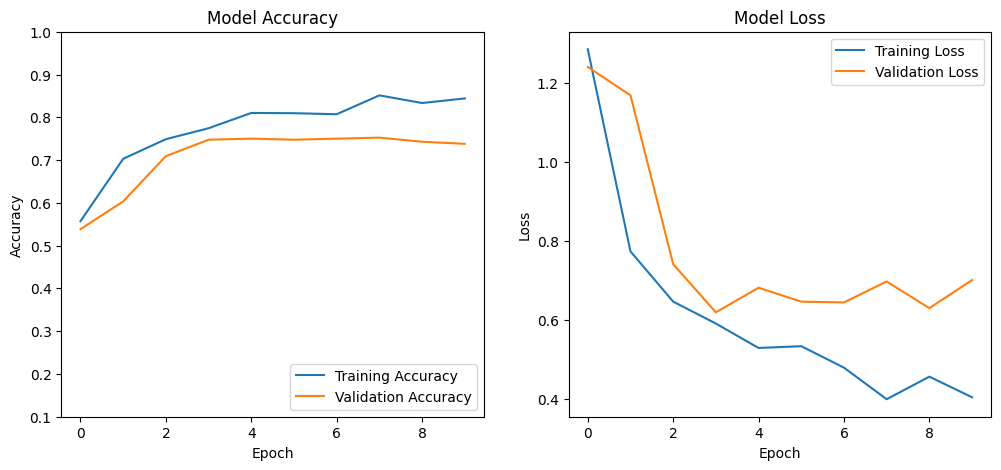

In [15]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_CNN2['accuracy'])
plt.plot(history_CNN2['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1, 1)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_CNN2['loss'])
plt.plot(history_CNN2['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')

plt.show()

In [16]:
vgg_model.save('VGG16_model_16batchsize.h5')

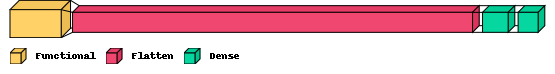

In [28]:
import visualkeras

visualkeras.layered_view(vgg_model,  legend=True)